In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR*5)
overlap = 0 #int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [7]:
path_to_db='../../../../ESC-50/'
audio_dir = path_to_db + 'audio/'
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_target)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_target)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [8]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, orig_blocksize, orig_overlap)
print(c_data.shape)

	Processing Time: 61.63839411735535
(400, 1, 80000)


In [23]:
c_data = c_data.squeeze()
print(c_data.shape)

(400, 80000)


In [9]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [10]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'clapping', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

# Training

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1,blocksize)))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [35]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)

clf = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=100, 
                       batch_size=36, 
                       validation_split=0.15)

history = clf.fit(train_X[:,np.newaxis,:], train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 1, 100)            32040400  
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 50)                30200     
__________

272/272 [==============================] - 5s 18ms/step - loss: 5.9198 - acc: 0.6287 - val_loss: 4.6499 - val_acc: 0.7083
Epoch 51/100
272/272 [==============================] - 5s 18ms/step - loss: 5.9198 - acc: 0.6287 - val_loss: 4.6499 - val_acc: 0.7083
Epoch 52/100
272/272 [==============================] - 5s 18ms/step - loss: 5.9198 - acc: 0.6287 - val_loss: 4.6499 - val_acc: 0.7083
Epoch 53/100
272/272 [==============================] - 5s 18ms/step - loss: 5.9198 - acc: 0.6287 - val_loss: 4.6499 - val_acc: 0.7083
Epoch 54/100
272/272 [==============================] - 5s 18ms/step - loss: 5.9198 - acc: 0.6287 - val_loss: 4.6499 - val_acc: 0.7083
Epoch 55/100
272/272 [==============================] - 5s 18ms/step - loss: 5.9198 - acc: 0.6287 - val_loss: 4.6499 - val_acc: 0.7083
Epoch 56/100
272/272 [==============================] - 5s 18ms/step - loss: 5.9198 - acc: 0.6287 - val_loss: 4.6499 - val_acc: 0.7083
Epoch 57/100
272/272 [==============================] - 5s 18ms/step

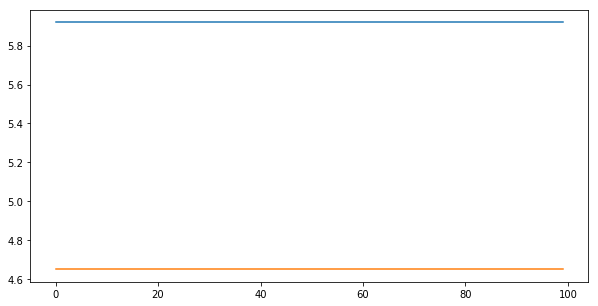

In [38]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.6375
Confusion matrix, without normalization
[[ 0 29]
 [ 0 51]]


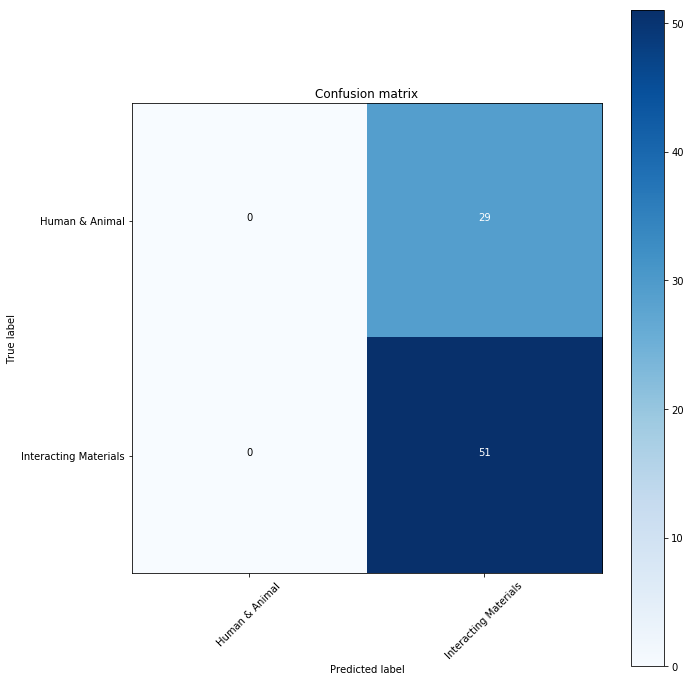

In [41]:
test_X = scaler.transform(test_X)

pred = clf.predict(test_X[:, np.newaxis,:])
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [42]:
all_df = df[df.fold == 1]

NameError: name 'df' is not defined

In [18]:
all_df.head()

,target,h_target,metadata,fold
56,40,1,"[[81.63621416748332, 69.08677828643624, 65.870...",1
65,12,1,"[[130.2765410501758, 63.32512240419306, 67.715...",1
109,35,1,"[[29.16026369721113, 26.328893125416254, 22.94...",1
111,38,1,"[[93.13728394270349, 51.92924338824044, 50.861...",1
120,19,1,"[[68.15750301969466, 56.930617834758124, 42.26...",1


In [19]:
X = all_df.metadata.values
y = all_df['target']
# X = scaler.transform(X)
# X = feat_red.transform(X)
X = pad_sequences(X, padding='post', maxlen=50)

0.10687022900763359
Confusion matrix, without normalization
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 2 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0 0 0 2 0 1 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 1]
 [3 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [2 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 

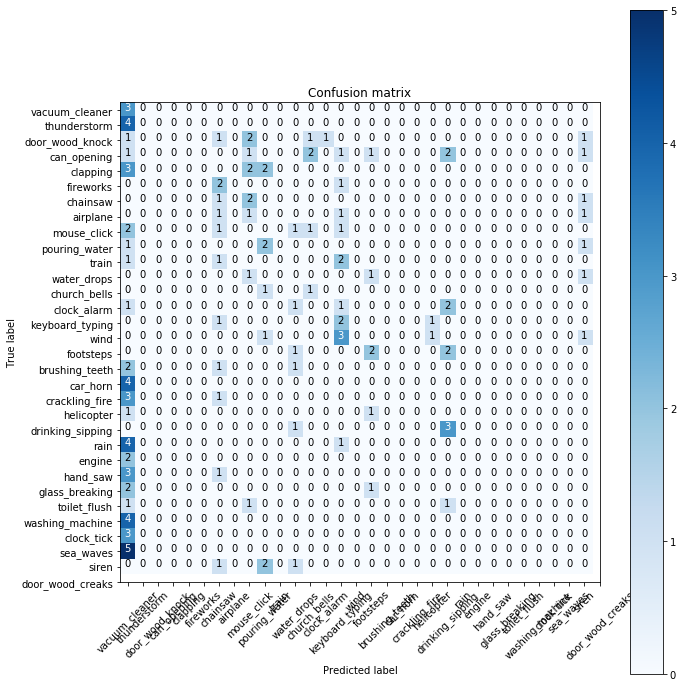

In [20]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

In [21]:
import seaborn as sns
misclassified = {
    'actual': [],
    'predicted': []
}
for cls in red_class:
    misclassified[cls] = []

for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['actual'].append(classes[int(row[1]['target'])])
        misclassified['predicted'].append(classes[p])
        for i, cls in enumerate(red_class):
            misclassified[cls].append(prob[i])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,actual,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,helicopter,0.033570,0.045376,0.008353,0.060127,0.025223,0.001741,0.043517,0.010483,0.065697,...,0.053306,0.054435,0.023761,0.058461,0.060778,0.024942,0.069055,0.064242,0.006830,0.012492
1,crackling_fire,0.033570,0.045376,0.008353,0.060127,0.025223,0.001741,0.043517,0.010483,0.065697,...,0.053306,0.054435,0.023761,0.058461,0.060778,0.024942,0.069055,0.064242,0.006830,0.012492
2,washing_machine,0.001126,0.000859,0.144240,0.000294,0.000447,0.016782,0.002657,0.165151,0.000777,...,0.003950,0.002584,0.006648,0.000393,0.000383,0.010747,0.000597,0.000872,0.166984,0.015233
3,clock_tick,0.033570,0.045376,0.008353,0.060127,0.025223,0.001741,0.043517,0.010483,0.065697,...,0.053306,0.054435,0.023761,0.058461,0.060778,0.024942,0.069055,0.064242,0.006830,0.012492
4,thunderstorm,0.103021,0.008251,0.022848,0.011461,0.153541,0.007473,0.021953,0.013158,0.013849,...,0.007468,0.006577,0.014186,0.008668,0.008256,0.040622,0.018927,0.011180,0.022560,0.078359


In [22]:
average_prob = misclassified.groupby('predicted').mean()
average_prob.head()

,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,crackling_fire,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
predicted,,,,,,,,,,,,,,,,,,,,,
can_opening,0.000818,0.001329,0.071934,0.000575,0.000409,0.095849,0.001247,0.049504,0.000645,0.097870,...,0.006946,0.000390,0.028337,0.000769,0.000669,0.009812,0.000495,0.000351,0.091149,0.038099
clapping,0.060811,0.011019,0.044414,0.019170,0.053744,0.027867,0.025524,0.004385,0.003104,0.036776,...,0.003419,0.001902,0.029385,0.007323,0.009089,0.035456,0.018006,0.004773,0.037391,0.052831
clock_tick,0.011465,0.000709,0.035438,0.000511,0.003949,0.019644,0.054273,0.056541,0.000648,0.018274,...,0.001869,0.000391,0.009922,0.001178,0.000444,0.022997,0.003039,0.000821,0.039377,0.043967
door_wood_knock,0.001993,0.014423,0.082375,0.003550,0.003505,0.114093,0.001109,0.078754,0.002086,0.056510,...,0.010557,0.002262,0.083769,0.002352,0.005249,0.018505,0.001888,0.001167,0.053410,0.023937
drinking_sipping,0.003175,0.008315,0.029823,0.011442,0.013486,0.060628,0.001878,0.119922,0.006484,0.049494,...,0.002202,0.001115,0.068976,0.007527,0.010923,0.022162,0.001016,0.001252,0.177685,0.049954


In [23]:
average_prob = misclassified.groupby('actual').mean()
average_prob

,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,crackling_fire,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
actual,,,,,,,,,,,,,,,,,,,,,
airplane,0.033570,0.045376,0.008353,0.060127,0.025223,0.001741,0.043517,0.010483,0.065697,0.015727,...,0.053306,0.054435,0.023761,0.058461,0.060778,0.024942,0.069055,0.064242,0.006830,0.012492
brushing_teeth,0.066310,0.017993,0.029089,0.021000,0.067860,0.009552,0.026154,0.014920,0.020418,0.021586,...,0.022167,0.018451,0.015922,0.029548,0.020345,0.034646,0.030582,0.024349,0.038527,0.032992
can_opening,0.001313,0.003674,0.010532,0.005131,0.005783,0.106879,0.000657,0.060884,0.002976,0.022761,...,0.001387,0.000372,0.031488,0.003439,0.004733,0.008591,0.000394,0.000561,0.074324,0.025829
car_horn,0.022653,0.030694,0.029547,0.040277,0.016952,0.033111,0.029427,0.023490,0.044013,0.043108,...,0.037852,0.036420,0.025287,0.039231,0.040742,0.019899,0.046202,0.042945,0.034936,0.021028
chainsaw,0.033570,0.045376,0.008353,0.060127,0.025223,0.001741,0.043517,0.010483,0.065697,0.015727,...,0.053306,0.054435,0.023761,0.058461,0.060778,0.024942,0.069055,0.064242,0.006830,0.012492
church_bells,0.033570,0.045376,0.008353,0.060127,0.025223,0.001741,0.043517,0.010483,0.065697,0.015727,...,0.053306,0.054435,0.023761,0.058461,0.060778,0.024942,0.069055,0.064242,0.006830,0.012492
clapping,0.025853,0.022748,0.041993,0.025754,0.039050,0.038288,0.018792,0.050955,0.025413,0.032046,...,0.026391,0.021881,0.037435,0.030306,0.025697,0.023175,0.028543,0.027225,0.063930,0.024031
clock_alarm,0.050933,0.036095,0.011977,0.047961,0.057303,0.003174,0.038126,0.011152,0.052735,0.019258,...,0.041846,0.042470,0.021367,0.046013,0.047648,0.028862,0.056523,0.050976,0.010762,0.028959
clock_tick,0.017194,0.023353,0.040144,0.030351,0.012816,0.048795,0.022382,0.029994,0.033171,0.056798,...,0.030126,0.027412,0.026049,0.029615,0.030724,0.017377,0.034775,0.032296,0.048989,0.025296


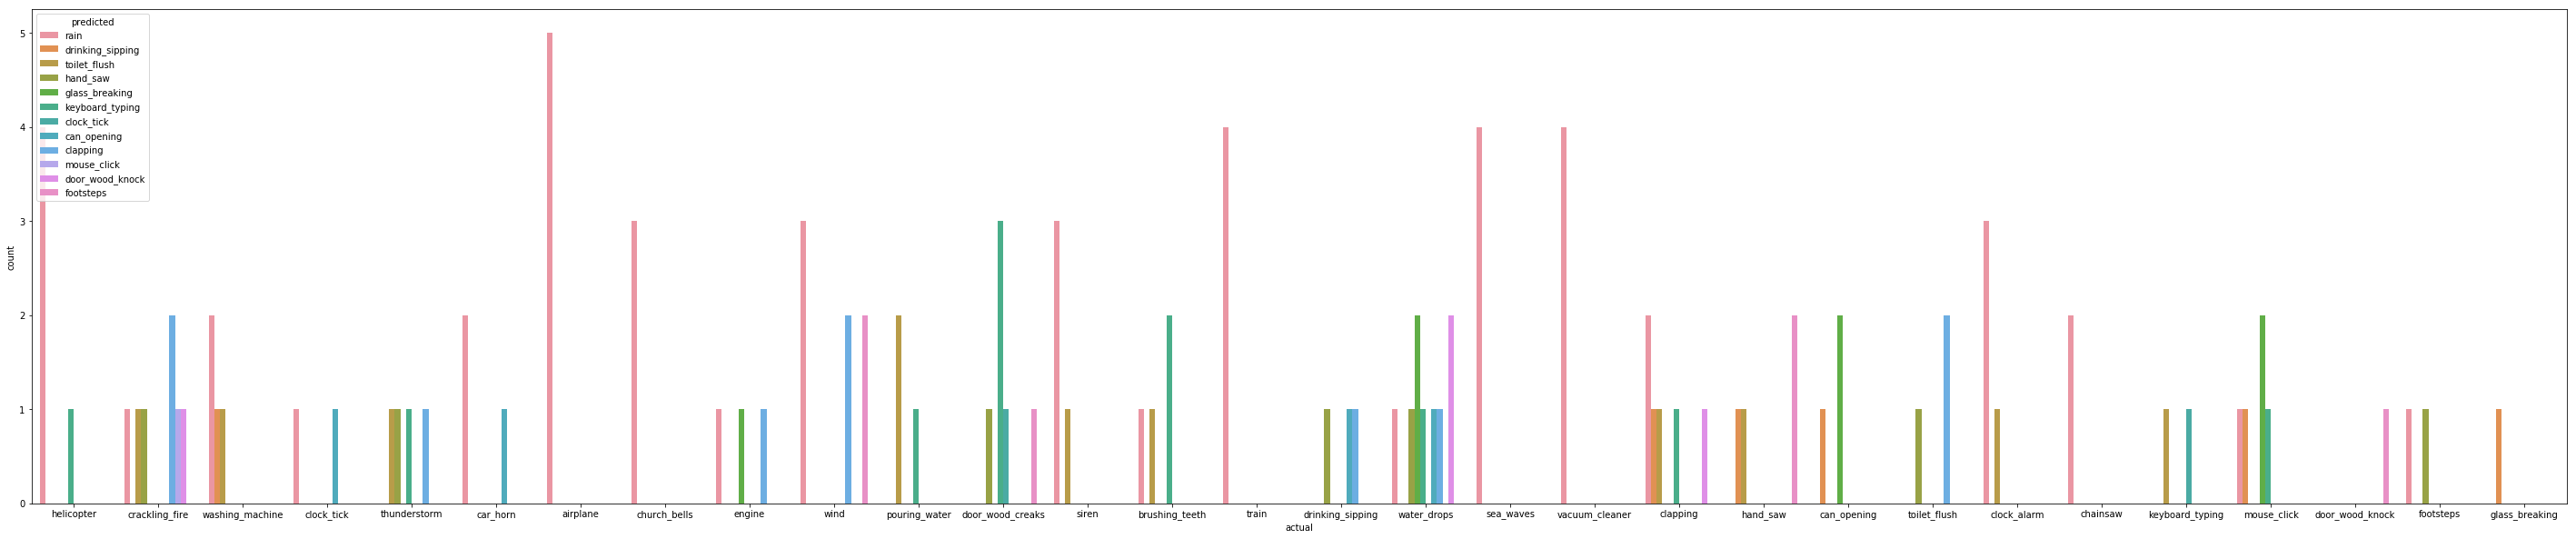

In [24]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='actual', hue='predicted',data=misclassified)